# 1. Preparação do notebook

In [1]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import warnings
import matplotlib.pyplot as plt

In [2]:
# Oculta avisos específicos do NumPy
warnings.filterwarnings("ignore", category=UserWarning, module="numpy")

# 2. Leitura dos dados

In [3]:
# Abertura da caixa de diálogo para selecionar o arquivo
uploaded = files.upload()

# Obtenção do nome do arquivo selecionado
filename = list(uploaded.keys())[0]

# Leitura do arquivo para um DataFrame
df = pd.read_excel(filename)

df.head()

Saving [BM Jumps 1] Séries temporais.xlsx to [BM Jumps 1] Séries temporais.xlsx


,bm_jumps_1_W,bm_jumps_1_MA,bm_jumps_1_KS,bm_jumps_1_SES,bm_jumps_1_QES,bm_jumps_1_SPLINES,bm_jumps_1_LOWESS,bm_jumps_1_RF,bm_jumps_1_KALMAN
0,0.496714,NaN,2.009838,0.496714,0.358450,0.496710,-9.903648,0.496714,0.496714
1,0.358450,NaN,-4.479763,0.496714,0.265813,0.358484,-9.885946,0.455235,0.413756
2,1.006138,NaN,-24.637139,0.455235,0.162267,1.005977,-9.868145,0.620506,0.778299
3,-9.844037,NaN,-19.806323,0.620506,0.309407,-135.982152,-9.850246,-40.360482,-83.691785
4,105.096588,1.337097,24.041033,-40.360482,-44.773039,140.804575,-9.832246,13.989754,55.043402


# 3. Previsão da série temporal

## 3.1. Criação de janelas deslizantes

In [4]:
# Função para criar janelas deslizantes
def create_sliding_windows(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

In [5]:
# Seleção da série
series = df['bm_jumps_1_MA'].dropna().values

# Criação da janela deslizante
window_size = 1
X, y = create_sliding_windows(series, window_size)

In [6]:
X

array([[   1.3370971 ],
       [   1.64992985],
       [   2.30625803],
       ...,
       [ -28.63059332],
       [ -29.95147167],
       [-167.69202664]])

In [7]:
y

array([   1.64992985,    2.30625803,    2.98653544, ...,  -29.95147167,
       -167.69202664,  -29.17895993])

## 3.2. Normalização

In [8]:
# Função para normalização Min-Max
def normalize_series(series):
    scaler = RobustScaler()
    series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    return series_scaled, scaler

In [9]:
# Normalização dos dados
X_scaled, scaler_X = normalize_series(X.flatten())
y_scaled, scaler_y = normalize_series(y)

X_scaled = X_scaled.reshape(-1, window_size)

## 3.2. Treinamento do modelo

In [10]:
# Definição do modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
        out, _ = self.lstm(x.unsqueeze(-1), (h0, c0))  # Ajuste para entrada correta
        out = self.fc(out[:, -1, :])
        return out

# Função para treinar LSTM com otimização de hiperparâmetros
def train_lstm(X_train, y_train, input_size):
    best_model = None
    best_loss = float('inf')
    param_grid = {
        'hidden_size': [10, 50, 100],
        'num_layers': [1, 2, 3],
        'learning_rate': [0.001, 0.01]
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for hidden_size in param_grid['hidden_size']:
        for num_layers in param_grid['num_layers']:
            for lr in param_grid['learning_rate']:
                model = LSTMModel(input_size, hidden_size, num_layers).to(device)
                criterion = nn.SmoothL1Loss(beta=1.0)
                optimizer = optim.Adam(model.parameters(), lr=lr)

                X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
                y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

                for epoch in range(100):
                    model.train()
                    optimizer.zero_grad()
                    outputs = model(X_train_tensor)
                    loss = criterion(outputs, y_train_tensor)
                    loss.backward()
                    optimizer.step()

                if loss.item() < best_loss:
                    best_loss = loss.item()
                    best_model = model

    return best_model

In [11]:
# Divisão entre treino e teste (70% treino, 30% teste)
split_idx = int(0.7 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# Treinamento do modelo ELM
lstm_model = train_lstm(X_train, y_train, input_size=1)

## 3.3. Avaliação do modelo

In [12]:
# Previsões no conjunto de treino
y_train_pred_scaled = lstm_model(torch.tensor(X_train, dtype=torch.float32)).detach().numpy().flatten()
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

# Previsões no conjunto de teste
y_test_pred_scaled = lstm_model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy().flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# DataFrames com previsões
train_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten(),
                              'Predicted': y_train_pred})

test_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(),
                             'Predicted': y_test_pred})

In [13]:
# Cálculo do sMAPE
def smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

smape_train = smape(train_results['Actual'].values, train_results['Predicted'].values)
smape_test = smape(test_results['Actual'].values, test_results['Predicted'].values)

print(f'sMAPE Treino: {smape_train:.2f}%')
print(f'sMAPE Teste: {smape_test:.2f}%')

sMAPE Treino: 12.07%
sMAPE Teste: 32.50%


In [14]:
# Cálculo do RMSE
def rmse(actual, predicted):
    return np.sqrt(np.mean((predicted - actual) ** 2))

rmse_train = rmse(train_results['Actual'].values, train_results['Predicted'].values)
rmse_test = rmse(test_results['Actual'].values, test_results['Predicted'].values)

print(f'RMSE Treino: {rmse_train:.2f}')
print(f'RMSE Teste: {rmse_test:.2f}')

RMSE Treino: 8.65
RMSE Teste: 42.99


In [15]:
# Cálculo do Huber Loss
def huber_loss(actual, predicted, delta=1.0):
    error = predicted - actual
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error ** 2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

huber_loss_train = huber_loss(train_results['Actual'].values, train_results['Predicted'].values)
huber_loss_test = huber_loss(test_results['Actual'].values, test_results['Predicted'].values)

print(f'Huber Loss Treino: {huber_loss_train:.2f}')
print(f'Huber Loss Teste: {huber_loss_test:.2f}')

Huber Loss Treino: 3.32
Huber Loss Teste: 16.00


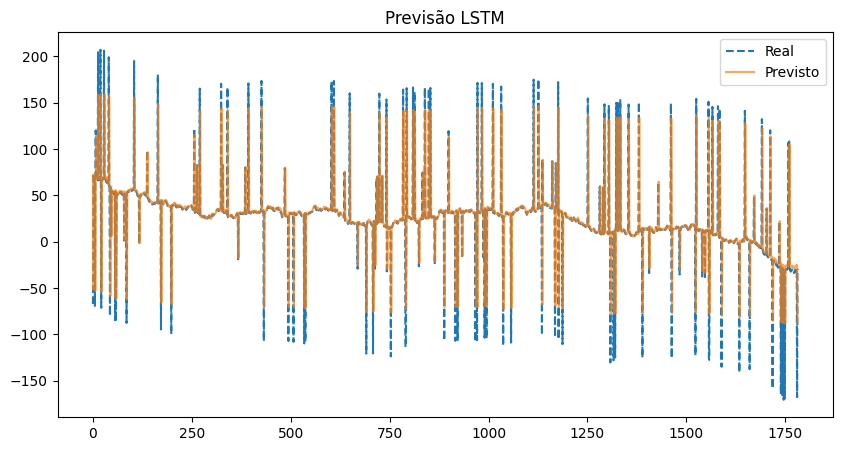

In [16]:
# Gráfico Real x Previsto
plt.figure(figsize=(10, 5))
plt.plot(test_results['Actual'], label='Real', linestyle='dashed')
plt.plot(test_results['Predicted'], label='Previsto', alpha=0.7)
plt.legend()
plt.title(f'Previsão LSTM')
plt.show()

# 4. Análise dos erros

In [17]:
results = pd.concat([train_results, test_results])
results['Error'] = results['Actual'] - results['Predicted']

Q1 = results['Actual'].quantile(0.25)
Q3 = results['Actual'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = results[(results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)]
outliers

,Actual,Predicted,Error
13,204.451928,67.238243,137.213685
19,206.990004,69.270302,137.719702
28,206.083524,68.720886,137.362638
40,198.966417,62.734489,136.231928
43,-79.902244,59.700531,-139.602775
56,-84.749200,55.423519,-140.172719
58,-86.228604,55.264610,-141.493214
85,-87.678667,51.799603,-139.478269
104,194.871437,57.058327,137.813111
164,180.185768,41.531467,138.654300


In [18]:
# Identifica os outliers
results['Outlier'] = (results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)
results.head()

,Actual,Predicted,Error,Outlier
0,1.649930,1.854499,-0.204570,False
1,2.306258,2.155380,0.150878,False
2,2.986535,2.787838,0.198698,False
3,30.970703,3.445087,27.525616,False
4,3.705431,31.579845,-27.874414,False


In [19]:
# Teste de Mann-Whitney
from scipy.stats import mannwhitneyu

# Separa os erros dos dois grupos
erros_outliers = results[results['Outlier']]['Error']
erros_normais = results[~results['Outlier']]['Error']

# Aplicação do teste de Mann-Whitney
stat, p = mannwhitneyu(erros_outliers, erros_normais, alternative='greater')

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 35516.0
Valor-p: 1.0
Não há evidência suficiente para afirmar que os outliers causam maiores erros.


In [20]:
# Teste de Kruskal-Wallis
from scipy.stats import kruskal

# Classificação dos pontos
results['Grupo'] = 'normal'
results.loc[results['Actual'] < lower_bound, 'Grupo'] = 'outlier_negativo'
results.loc[results['Actual'] > upper_bound, 'Grupo'] = 'outlier_positivo'

# Separa os erros por grupo
erros_normais = results[results['Grupo'] == 'normal']['Error']
erros_outliers_neg = results[results['Grupo'] == 'outlier_negativo']['Error']
erros_outliers_pos = results[results['Grupo'] == 'outlier_positivo']['Error']

# Aplicação do teste de Kruskal-Wallis
stat, p = kruskal(erros_normais, erros_outliers_neg, erros_outliers_pos)

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 156.47450320584176
Valor-p: 1.0519457650764093e-34
Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.


In [21]:
# Análise da correlação de Spearman
from scipy.stats import spearmanr

# Calcular a correlação de Spearman
correlacao, p_valor = spearmanr(results['Outlier'], results['Error'])

# Exibir resultados
print(f"Correlação: {correlacao}")
print(f"Valor-p: {p_valor}")

if p_valor < 0.05:
    print("Existe uma relação significativa entre outliers e a magnitude do erro.")
else:
    print("Não há evidência estatística de que os outliers impactam significativamente os erros.")

Correlação: -0.1258048526906882
Valor-p: 2.2247312771499275e-22
Existe uma relação significativa entre outliers e a magnitude do erro.
